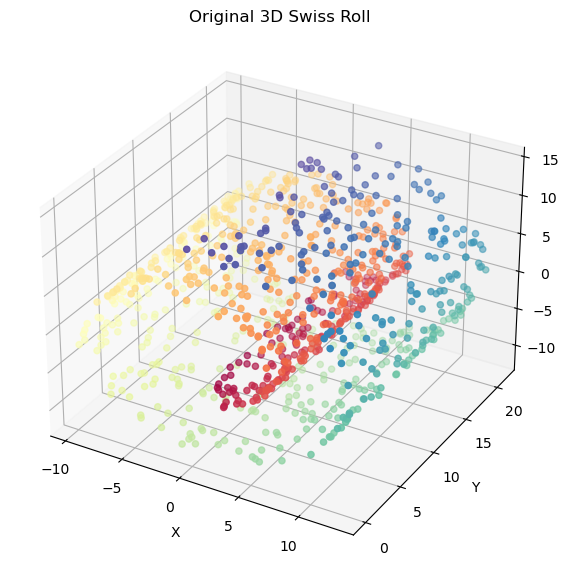

In [2]:
# Showing Swiss Roll dataset in 3D

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

n_samples = 1000
X, color = make_swiss_roll(n_samples, noise=0.15, random_state=0)

fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original 3D Swiss Roll")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

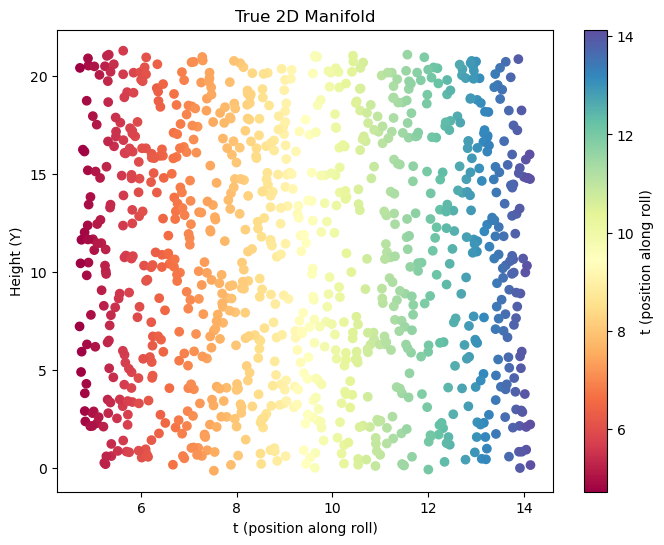

In [7]:
# True 2D Manifold
plt.figure(figsize=(8, 6))
plt.scatter(color, X[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("True 2D Manifold")
plt.xlabel("t (position along roll)")
plt.ylabel("Height (Y)")
plt.colorbar(label="t (position along roll)")
plt.show()

Stage 1: 250 iterations - KL Divergence: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.00, Trustworthiness: 0.93, Continuity: 0.98
Stage 2: 500 iterations - KL Divergence: 0.52, Trustworthiness: 1.00, Continuity: 0.99
Stage 3: 750 iterations - KL Divergence: 0.51, Trustworthiness: 1.00, Continuity: 0.99
Stage 4: 1000 iterations - KL Divergence: 0.51, Trustworthiness: 1.00, Continuity: 0.99


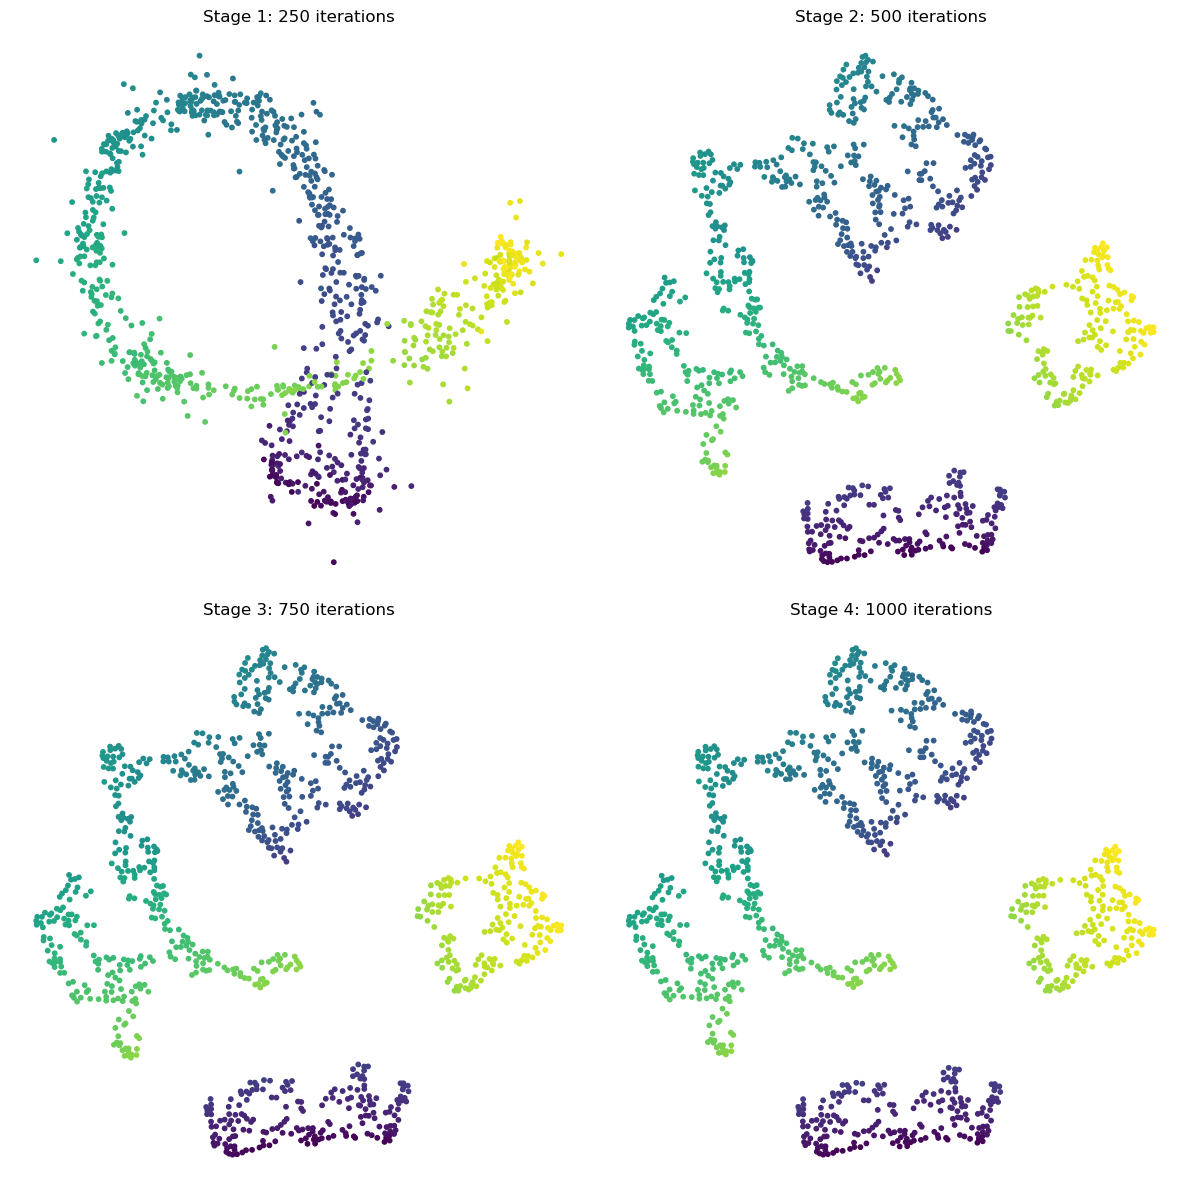

In [14]:
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE, trustworthiness

def continuity(X_high, X_low, k=5):
    n = X_high.shape[0]
    dist_high = squareform(pdist(X_high))
    dist_low = squareform(pdist(X_low))
    nn_high = np.argsort(dist_high, axis=1)[:, 1:k+1]
    nn_low = np.argsort(dist_low, axis=1)[:, 1:k+1]
    
    sum_cont = 0
    for i in range(n):
        V_i = set(nn_high[i]) - set(nn_low[i])
        ranks_low = np.argsort(np.argsort(dist_low[i]))
        for j in V_i:
            rank = ranks_low[j]
            if rank > k:
                sum_cont += (rank - k)
    
    return 1 - (2 / (n * k * (2 * n - 3 * k - 1))) * sum_cont

def plot_tsne(iterations, X, color, ax, title):
    tsne = TSNE(n_components=2, n_iter=iterations, perplexity=30, learning_rate=200, random_state=0)
    X_tsne = tsne.fit_transform(X)
    
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color, cmap='viridis', s=10)
    ax.set_title(title)
    ax.axis('off')
    
    kl_divergence = tsne.kl_divergence_
    trust = trustworthiness(X, X_tsne, n_neighbors=5)
    cont = continuity(X, X_tsne, k=5)
    
    return kl_divergence, trust, cont

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

stages = [250, 500, 750, 1000]
titles = [f'Stage {i+1}: {iters} iterations' for i, iters in enumerate(stages)]

for i, iters in enumerate(stages):
    kl, trust, cont = plot_tsne(iters, X, color, axes[i], titles[i])
    print(f'{titles[i]} - KL Divergence: {kl:.2f}, Trustworthiness: {trust:.2f}, Continuity: {cont:.2f}')

plt.tight_layout()
plt.show()

C:\Users\ASUS  N551JW\AppData\Local\Temp\ipykernel_5032\971171795.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


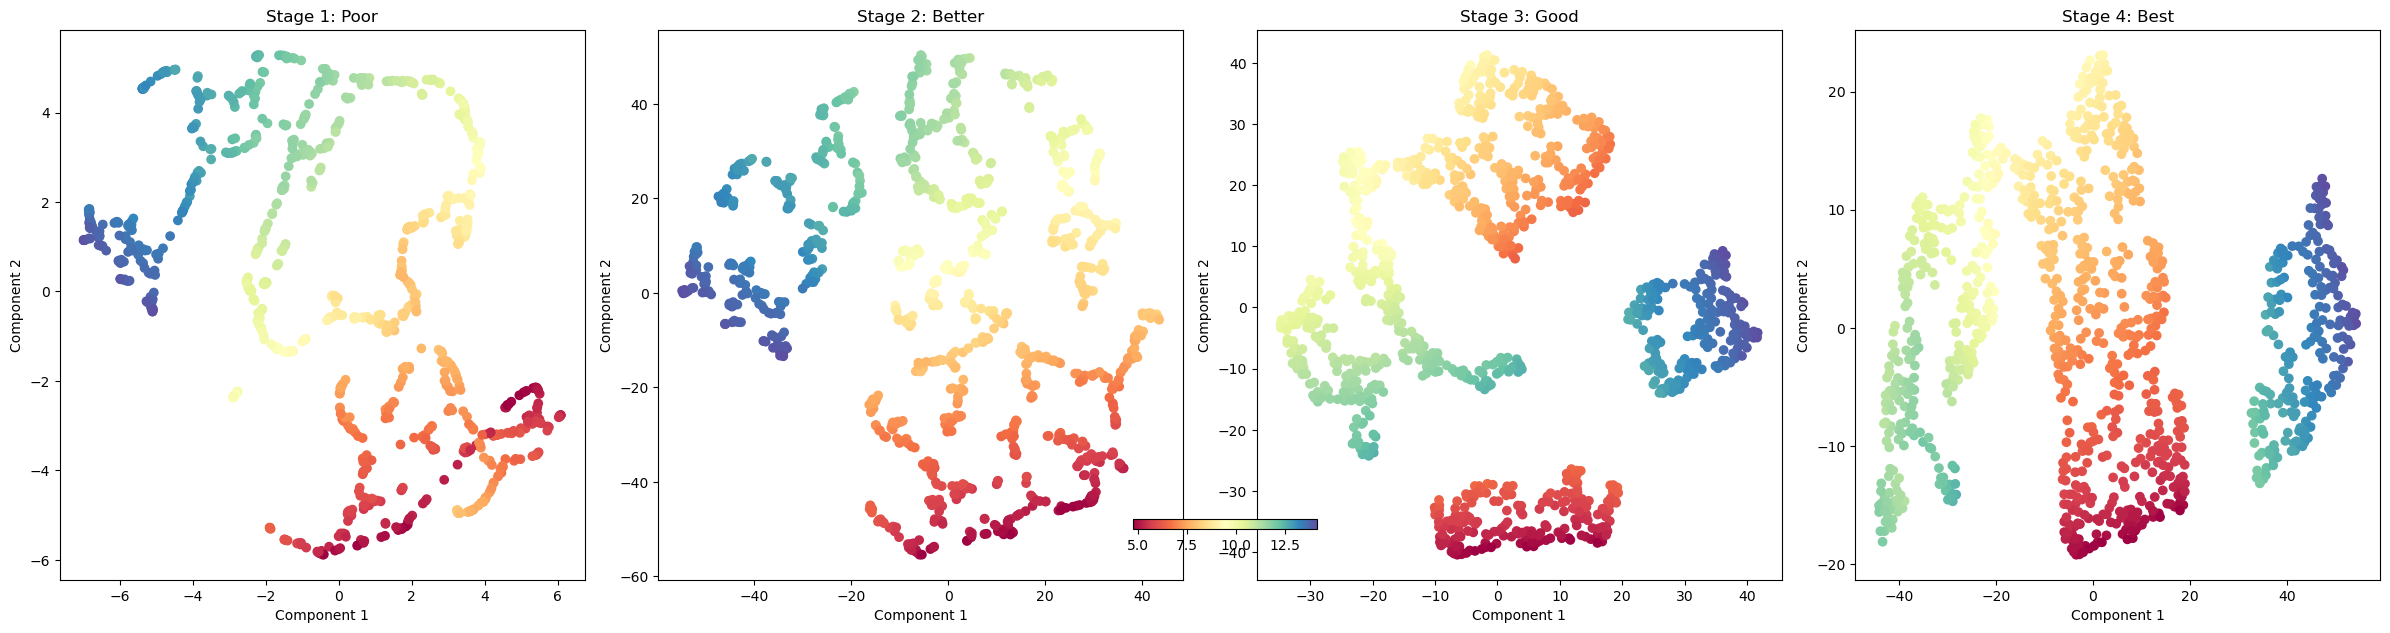

In [12]:
from sklearn.manifold import TSNE
import pandas as pd

tsne_params = [
    {'n_iter': 250, 'perplexity': 5, 'learning_rate': 10, 'init': 'random'},   # Poor
    {'n_iter': 500, 'perplexity': 10, 'learning_rate': 100, 'init': 'random'}, # Better
    {'n_iter': 1000, 'perplexity': 30, 'learning_rate': 200, 'init': 'pca'},   # Good
    {'n_iter': 2000, 'perplexity': 40, 'learning_rate': 300, 'init': 'pca'},   # Best
]

embeddings = []
kl_divs = []
trusts = []

for p in tsne_params:
    tsne = TSNE(n_components=2, random_state=0, **p, verbose=0)
    X_embedded = tsne.fit_transform(X)
    embeddings.append(X_embedded)
    kl_divs.append(tsne.kl_divergence_)
    trusts.append(trustworthiness(X, X_embedded, n_neighbors=10))

fig, axes = plt.subplots(1, 4, figsize=(24, 6))
titles = [
    "Stage 1: Poor",
    "Stage 2: Better",
    "Stage 3: Good",
    "Stage 4: Best"
]

for i, ax in enumerate(axes):
    sc = ax.scatter(embeddings[i][:, 0], embeddings[i][:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title(titles[i])
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

fig.colorbar(sc, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)

plt.tight_layout()
plt.show()

In [13]:
df = pd.DataFrame({
    "Stage": titles,
    "KL Divergence": kl_divs,
    "Trustworthiness": trusts
})
print(df)

             Stage  KL Divergence  Trustworthiness
0    Stage 1: Poor  1.797693e+308         0.995955
1  Stage 2: Better   5.227337e-01         0.998781
2    Stage 3: Good   5.090890e-01         0.999413
3    Stage 4: Best   5.023280e-01         0.999446
